In [1]:

import os

import matplotlib.pyplot as plt
import numpy as np
import torch
from l5kit.configs import load_config_data
from l5kit.data import ChunkedDataset
from l5kit.data import LocalDataManager
from l5kit.dataset import EgoDataset
from l5kit.geometry import angular_distance
from l5kit.geometry import transform_points
from l5kit.rasterization import build_rasterizer
from l5kit.visualization import draw_trajectory
from l5kit.visualization import PREDICTED_POINTS_COLOR
from l5kit.visualization import TARGET_POINTS_COLOR
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from tqdm import tqdm

# matplotlib set style
plt.style.use('default')


## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [9]:
# set env variable for data
os.environ["L5KIT_DATA_FOLDER"] = "/mnt/share_disk/user/public/l5kit/prediction"
# os.environ["L5KIT_DATA_FOLDER"] = "/tmp/l5kit_data"
dm = LocalDataManager(None)
# get config

from pathlib import Path

project_path = "/mnt/share_disk/user/xijinhao/l5kit-model-based-offline-rl"
# project_path = "/mnt/share_disk/user/daixingyuan/l5kit"
cfg = load_config_data(str(Path(project_path, "scripts/offline_rl_config.yaml")))

import sys

# sys.path.append('/mnt/share_disk/user/xijinhao/l5kit-model-based-offline-rl')
sys.path.append('/mnt/share_disk/user/daixingyuan/l5kit')
from scripts.vectorized_offline_rl_model import VectorOfflineRLModel, EnsembleOfflineRLModel

os.environ["CUDA_VISIBLE_DEVICES"] = '2'
cfg

{'format_version': 7,
 'model_params': {'history_num_frames_ego': 1,
  'history_num_frames': 0,
  'history_num_frames_agents': 10,
  'step_time': 0.1,
  'disable_other_agents': False,
  'disable_map': False,
  'disable_lane_boundaries': True,
  'global_head_dropout': 0.0,
  'future_num_frames': 12,
  'detach_unroll': True,
  'warmup_num_frames': 0,
  'discount_factor': 0.8,
  'render_ego_history': True},
 'train_data_loader': {'key': 'scenes/train.zarr',
  'batch_size': 32,
  'pred_len': 10,
  'shuffle': True,
  'num_workers': 2,
  'perturb_probability': 0.5,
  'yaml': None},
 'val_data_loader': {'key': 'scenes/train.zarr',
  'batch_size': 16,
  'shuffle': False,
  'num_workers': 2,
  'history_num_frames_agents': 10},
 'raster_params': {'raster_size': [224, 224],
  'pixel_size': [0.5, 0.5],
  'ego_center': [0.5, 0.5],
  'map_type': 'py_satellite',
  'satellite_map_key': 'aerial_map/aerial_map.png',
  'semantic_map_key': 'semantic_map/semantic_map.pb',
  'dataset_meta_key': 'meta.json',

## Load the model

In [3]:
# model_path = "/tmp/planning_model.pt"
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model = torch.load(model_path).to(device)
# model = model.eval()


model_name = "Offline RL Planner"
weights_scaling = [1.0, 1.0, 1.0]
_num_predicted_frames = cfg["model_params"]["future_num_frames"]
_num_predicted_params = len(weights_scaling)
model = VectorOfflineRLModel(
    history_num_frames_ego=cfg["model_params"]["history_num_frames_ego"],
    history_num_frames_agents=cfg["model_params"]["history_num_frames_agents"],
    num_targets=_num_predicted_params * _num_predicted_frames,
    weights_scaling=weights_scaling,
    criterion=torch.nn.L1Loss(reduction="none"),
    global_head_dropout=cfg["model_params"]["global_head_dropout"],
    disable_other_agents=cfg["model_params"]["disable_other_agents"],
    disable_map=cfg["model_params"]["disable_map"],
    disable_lane_boundaries=cfg["model_params"]["disable_lane_boundaries"],
    cfg=cfg
)

num_ensemble = 4
model_list = [model for _ in range(num_ensemble)]

model_checkpoint = 44000

model_path0 = f"/mnt/share_disk/user/xijinhao/l5kit-model-based-offline-rl/tmpspeed_train/Offline RL Planner-train_flag_0signal_scene_13-il_weight_1.0-pred_weight_1.0-1/iter_{model_checkpoint:07}.pt"
model_path1 = f"/mnt/share_disk/user/xijinhao/l5kit-model-based-offline-rl/tmpspeed_train/Offline RL Planner-train_flag_1signal_scene_13-il_weight_1.0-pred_weight_1.0-1/iter_{model_checkpoint:07}.pt"
model_path2 = f"/mnt/share_disk/user/xijinhao/l5kit-model-based-offline-rl/tmpspeed_train/Offline RL Planner-train_flag_2signal_scene_13-il_weight_1.0-pred_weight_1.0-1/iter_{model_checkpoint:07}.pt"
model_path3 = f"/mnt/share_disk/user/xijinhao/l5kit-model-based-offline-rl/tmpspeed_train/Offline RL Planner-train_flag_3signal_scene_13-il_weight_1.0-pred_weight_1.0-1/iter_{model_checkpoint:07}.pt"

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_list[0].load_state_dict(torch.load(model_path0))
model_list[1].load_state_dict(torch.load(model_path1))
model_list[2].load_state_dict(torch.load(model_path2))
model_list[3].load_state_dict(torch.load(model_path3))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = EnsembleOfflineRLModel(model_list)
model = model.to(device)
model = model.eval()
torch.set_grad_enabled(False)


## Load the evaluation data
This is almost the exact same code you've already seen in the [training notebook](./train.ipynb). Apart from the different dataset we load, the biggest difference is that **we don't perturb our data here**.

When performing evaluation we're interested in knowing the performance on the annotated data, not on perturbed one.

In [10]:
# ===== INIT DATASET
from l5kit.random.random_generator import GaussianRandomGenerator
from l5kit.kinematic import AckermanPerturbation
from l5kit.vectorization.vectorizer_builder import build_vectorizer
from l5kit.dataset import EgoDatasetVectorized

eval_cfg = cfg["val_data_loader"]
rasterizer = build_rasterizer(cfg, dm)
eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()

mean_value=np.array([0.0,0.0,0.0])
std_value=np.array([0.5,1.5,np.pi/6])
AckermanPerturbation1=AckermanPerturbation(random_offset_generator=GaussianRandomGenerator(mean=mean_value,std=std_value),perturb_prob=0.5)


eval_dataset1 = EgoDataset(cfg, eval_zarr, rasterizer,perturbation=AckermanPerturbation1)
eval_dataset2 = EgoDataset(cfg, eval_zarr, rasterizer)

eval_dataloader1 = DataLoader(eval_dataset1, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"],
                             num_workers=eval_cfg["num_workers"])
eval_dataloader2 = DataLoader(eval_dataset2, shuffle=eval_cfg["shuffle"], batch_size=eval_cfg["batch_size"],
                             num_workers=eval_cfg["num_workers"])

# ===== INIT DATASET
# eval_cfg = cfg["val_data_loader"]
# eval_zarr = ChunkedDataset(dm.require(eval_cfg["key"])).open()
vectorizer = build_vectorizer(cfg, dm)
eval_vector_dataset = EgoDatasetVectorized(cfg, eval_zarr, vectorizer)

print(eval_dataset1)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


## Viz Raster and Vector

[[3.28626e-14 0.00000e+00]]
[[ 2.00000000e+00  3.87992405e-17  1.12000000e+02]
 [ 2.62078516e-17 -2.00000000e+00  1.12000000e+02]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


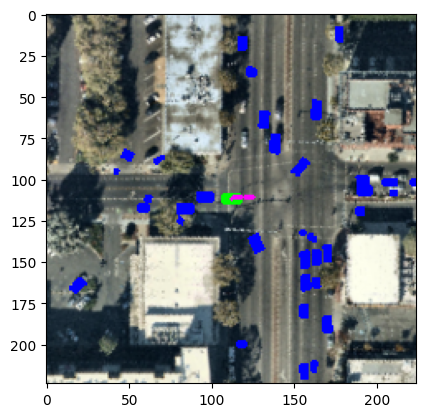

In [14]:
## Raster
scene_id = 13
frame_id = 200
data = eval_dataset1.get_scene_dataset(scene_id)[frame_id]

im = data["image"].transpose(1, 2, 0)
im = eval_dataset1.rasterizer.to_rgb(im)

print(data["history_positions"])
print(data["raster_from_agent"])

target_positions_pixels = transform_points(data["target_positions"], data["raster_from_agent"])
draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR,
                # yaws=data["target_yaws"]
                )

history_positions_pixels = transform_points(data["history_positions"], data["raster_from_agent"])
draw_trajectory(im, history_positions_pixels, TARGET_POINTS_COLOR,
                # yaws=data["target_yaws"]
                )

plt.imshow(im)
plt.show()

dict_values(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])
[20]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Output vehicle
[(4, 3), (30, 4, 3)]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.85 1.8 ]
Ego current state
[9.769963e-15 0.000000e+00 0.000000e+00] [0.] [4.87 1.8

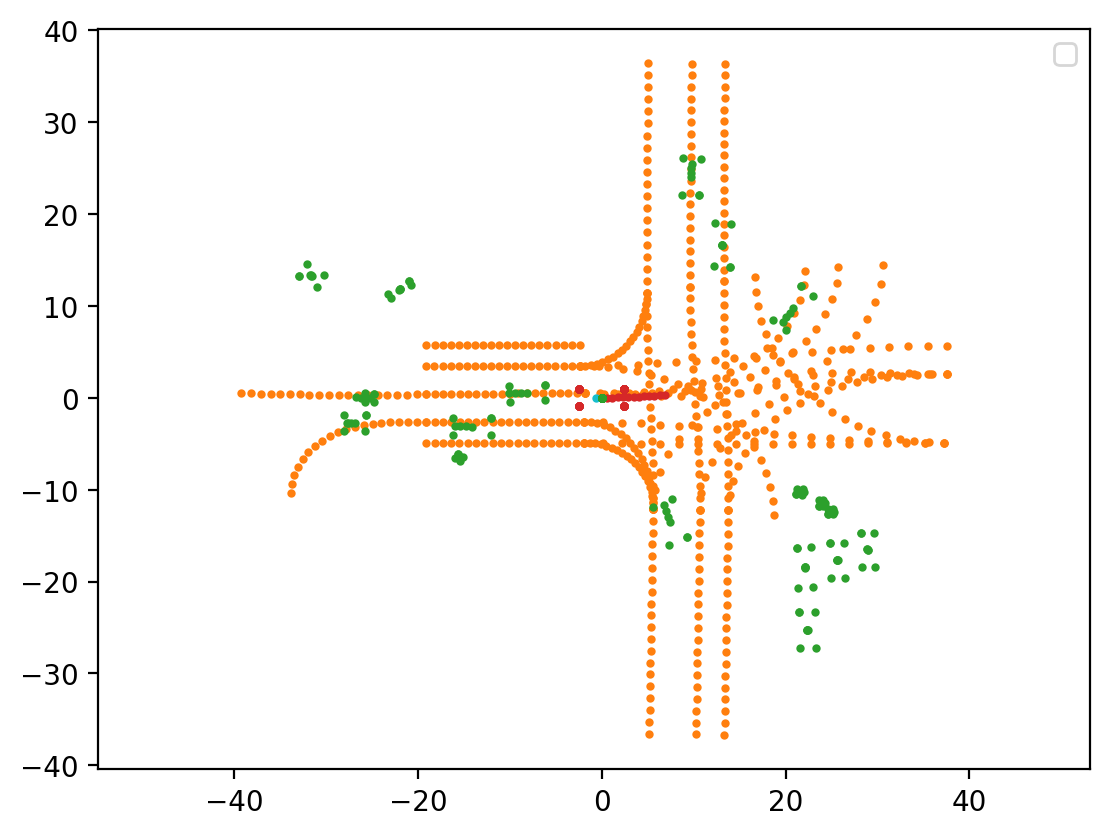

In [6]:
# Vector representation viz + bounding box

from l5kit.planning import utils

AGENT_TRAJECTORY_POLYLINE = "agent_trajectory_polyline"
AGENT_TRAJECTORY_POLYLINE_2 = "history_positions"
AGENT_YAWS = "history_yaws"
AGENT_EXTENT = "extent"

OTHER_AGENTS_POLYLINE = "other_agents_polyline"
OTHER_AGENTS_POLYLINE_2 = "all_other_agents_history_positions"
OTHER_AGENTS_YAWS = "all_other_agents_history_yaws"
OTHER_AGENTS_EXTENTS = "all_other_agents_history_extents"

agent_key_extent = [
    "extent",
    "all_other_agents_history_extents",
]

agent_key = [
    "agent_trajectory_polyline",
    "other_agents_polyline",
]

# point/vector form
import matplotlib.colors as mcolors

print(mcolors.TABLEAU_COLORS.values())

tr_sample = eval_vector_dataset.get_scene_dataset(scene_id)[frame_id]

# obstacle
polyline_keys = [
    "lanes_mid",
    # "crosswalks",
    # "lanes",
]
print([tr_sample[key].shape[-2] for key in polyline_keys])

num_lanes = 30
plt.figure(dpi=200)
for ix, key in enumerate(polyline_keys):
    i_label = 0
    for i in range(num_lanes):
        for x, y, z in tr_sample[key][i]:
            i_label += 1
            plt.plot(
                x, y, 'o', color=list(mcolors.TABLEAU_COLORS.values())[ix * 2 + 1], markersize=2,
            )
# vehicle
print("Output vehicle")
print([tr_sample[key].shape for key in agent_key])

EGO = "ego"
OTHER_AGENTS = "other_agents"


def get_ego_current_state(_frame):
    centroid = _frame[AGENT_TRAJECTORY_POLYLINE][0]
    yaws = _frame[AGENT_YAWS][0]
    extent = _frame[AGENT_EXTENT]

    return centroid, yaws, extent


def get_agent_current_state(_frame, agent_ix):
    centroid = _frame[OTHER_AGENTS_POLYLINE][agent_ix][0]
    yaws = _frame[OTHER_AGENTS_YAWS][agent_ix][0]
    extent = _frame[OTHER_AGENTS_EXTENTS][agent_ix][0]

    return centroid, yaws, extent


# Ego
for x, y, z in tr_sample[AGENT_TRAJECTORY_POLYLINE]:
    if x == 0:
        continue
    plt.plot(x, y, 'o', color=mcolors.TABLEAU_COLORS['tab:cyan'], markersize=2)

    centroid, yaws, extent = get_ego_current_state(tr_sample)
    print("Ego current state")
    print(centroid, yaws, extent)
    ego_bbox = utils._get_bounding_box(centroid=centroid, yaw=yaws, extent=extent)
    xx, yy = ego_bbox.exterior.xy
    plt.plot(xx, yy, 'o', color=mcolors.TABLEAU_COLORS['tab:cyan'], markersize=2)

# Ego planning traectory
for x, y in tr_sample["target_positions"]:
    if x == 0:
        continue
    plt.plot(x, y, 'o', color=mcolors.TABLEAU_COLORS['tab:red'], markersize=2)

    centroid, yaws, extent = get_ego_current_state(tr_sample)
    print("Ego current state")
    print(centroid, yaws, extent)
    ego_bbox = utils._get_bounding_box(centroid=centroid, yaw=yaws, extent=extent)
    xx, yy = ego_bbox.exterior.xy
    plt.plot(xx, yy, 'o', color=mcolors.TABLEAU_COLORS['tab:red'], markersize=2)

# Other agents
i = 0
for agent_id, agent_trajectory in enumerate(tr_sample[OTHER_AGENTS_POLYLINE]):
    i += 1
    for x, y, z in agent_trajectory:
        if x == 0:
            continue
        plt.plot(x, y, 'o',
                 color=list(mcolors.TABLEAU_COLORS.values())[ix * 2 + 2],
                 markersize=2)
    centroid, yaws, extent = get_agent_current_state(tr_sample, agent_id)
    ego_bbox = utils._get_bounding_box(centroid=centroid, yaw=yaws, extent=extent)
    xx, yy = ego_bbox.exterior.xy
    plt.plot(xx, yy, 'o',
             color=list(mcolors.TABLEAU_COLORS.values())[ix * 2 + 2],
             # color=mcolors.TABLEAU_COLORS['tab:cyan'],
             markersize=2)

plt.axis('equal')
plt.legend()
print("total", i)

print(tr_sample.keys())
print(tr_sample["target_positions"])


## Viz vector-based planning (Offline RL)

In [7]:
def get_inputs_offline_rl(_tr_sample):
    vector_input = _tr_sample.copy()
    # vector_input['extent'] = 1
    for k, vec in vector_input.items():
        try:
            vec_shape = vec.shape
            vector_input[k] = torch.tensor(vec[np.newaxis, ...], device=device)
            # print(k, vector_input[k].shape)
        except AttributeError:
            if k == "type":
                vector_input[k] = torch.tensor([vec], device=device)
                # print(k, vector_input[k])
    return vector_input




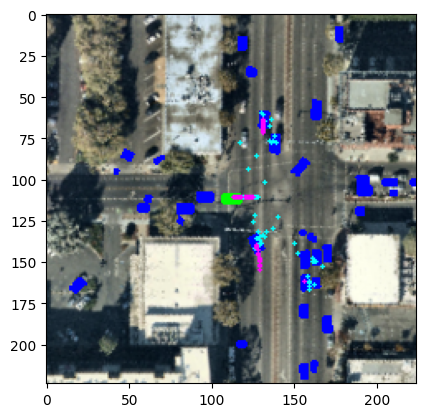

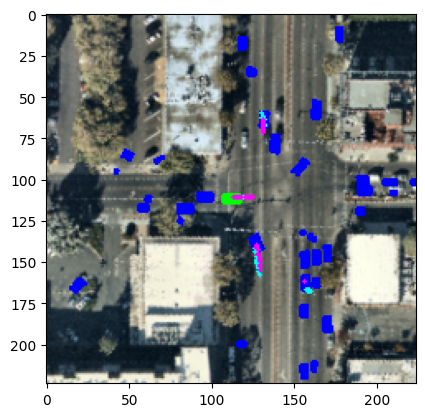

In [8]:

# 如果是MPC，则推断未来inference_mpc_step个点；如果是one-step，则推断future_num_frames（设定在offline_rl.yaml中）个点
INFERENCE_MPC = "mpc"
INFERENCE_ONE_STEP = "one_step"

def plot_offline_rl_planning_prediction(
        _image_data,
        _vector_data,
        inference = "mpc",
        inference_mpc_step = 15,
        plot_trajectory_target=True,
        plot_trajectory_planning=True,
        plot_other_agent_target=True,
        plot_other_agent_prediction=True,
        num_other_agent_to_plot=2,
        plot_yaws=False
):

    im = _image_data["image"].transpose(1, 2, 0)
    im = eval_dataset.rasterizer.to_rgb(im)

    # 如果是MPC，则推断未来inference_mpc_step个点；如果是one-step，则推断future_num_frames（设定在offline_rl.yaml中）个点
    first_step, planning_trajectory , one_step_planning, one_step_other_agents_prediction = model.mpc(_vector_data, inference_mpc_step)

    all_planning_prediction_positions = planning_trajectory["positions"].cpu().numpy()
    all_planning_prediction_yaws =  planning_trajectory["yaws"].cpu().numpy()

    if plot_trajectory_planning:
        if inference == INFERENCE_MPC:
            # mpc planning
            planning_positions = all_planning_prediction_positions[0, -inference_mpc_step:]
        elif inference == INFERENCE_ONE_STEP:
            # one-step planning
            planning_positions = one_step_planning.cpu().numpy()[:, :2]
            planning_yaws = one_step_planning.cpu().numpy()[:, 2]

        planning_positions = transform_points(planning_positions, _image_data["raster_from_agent"])

        if plot_yaws:
            planning_yaws = planning_yaws
        else:
            planning_yaws = None
        # blue line is prediction
        draw_trajectory(im, planning_positions, PREDICTED_POINTS_COLOR, yaws=planning_yaws)

    if plot_trajectory_target:
        target_positions_pixels = transform_points(_image_data["target_positions"], _image_data["raster_from_agent"])
        if plot_yaws:
            target_yaws = _image_data["target_yaws"]
        else:
            target_yaws = None
        # red line is target
        draw_trajectory(im, target_positions_pixels, TARGET_POINTS_COLOR, yaws=target_yaws)

    if plot_other_agent_prediction:
        if inference == INFERENCE_MPC:
            # mpc prediction
            other_agent_prediction = all_planning_prediction_positions[1:, -inference_mpc_step:]
        elif inference == INFERENCE_ONE_STEP:
            # one-step prediction
            other_agent_prediction = one_step_other_agents_prediction.cpu().numpy()[:, :, :2]

        for ix, other_agent in enumerate(other_agent_prediction):
            other_agent = transform_points(other_agent, _image_data["raster_from_agent"])
            draw_trajectory(im, other_agent, PREDICTED_POINTS_COLOR)

            if ix >= num_other_agent_to_plot:
                break

    if plot_other_agent_target:
        # red line is future trajectory of other agents
        for ix, other_agent in enumerate(tr_sample["all_other_agents_future_positions"]):
            other_agent = transform_points(other_agent, _image_data["raster_from_agent"])
            draw_trajectory(im, other_agent, TARGET_POINTS_COLOR)

            if ix >= num_other_agent_to_plot:
                break


    plt.imshow(im)
    plt.show()


scene_id = 13
frame_id = 200

data = eval_dataset.get_scene_dataset(scene_id)[frame_id]
tr_sample = eval_vector_dataset.get_scene_dataset(scene_id)[frame_id]

vector_data = get_inputs_offline_rl(tr_sample)

# todo 可以设置MPC的推断步数
inference_mpc_step = 15
num_other_agent_to_plot= 2

# blue lines are planning/prediction, red lines are targets
plot_offline_rl_planning_prediction(
    data,
    vector_data,
    inference=INFERENCE_MPC,
    inference_mpc_step=inference_mpc_step,
    num_other_agent_to_plot=num_other_agent_to_plot,
)

plot_offline_rl_planning_prediction(
    data,
    vector_data,
    inference=INFERENCE_ONE_STEP,
    num_other_agent_to_plot=num_other_agent_to_plot,
)

## MPC

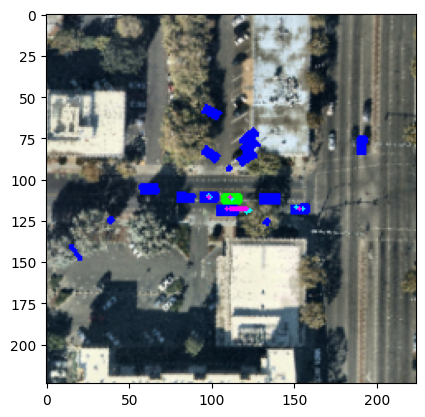

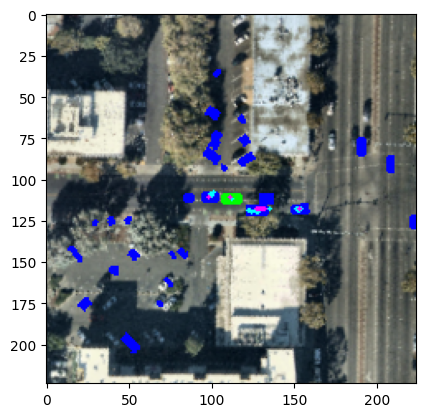

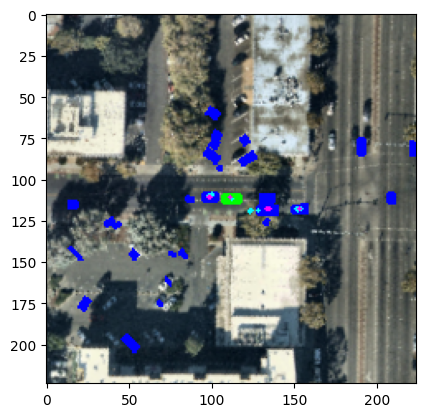

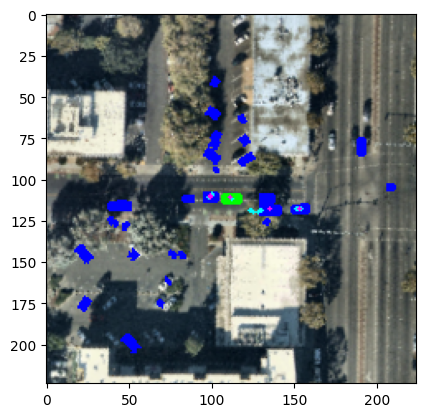

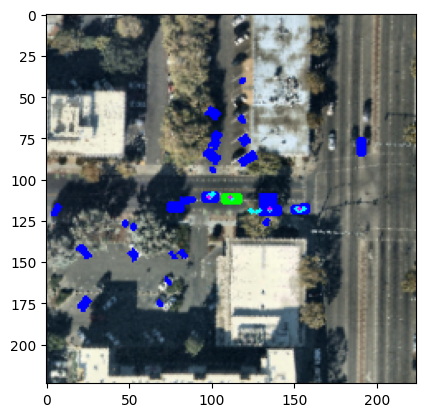

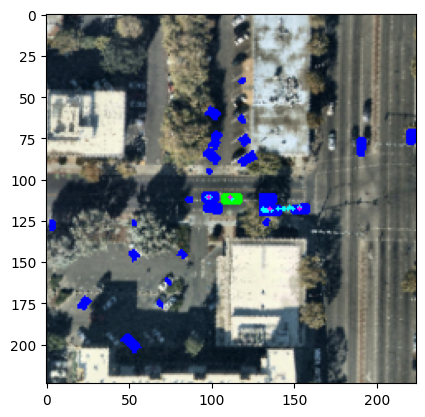

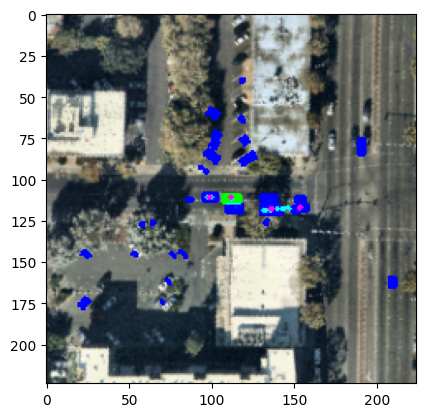

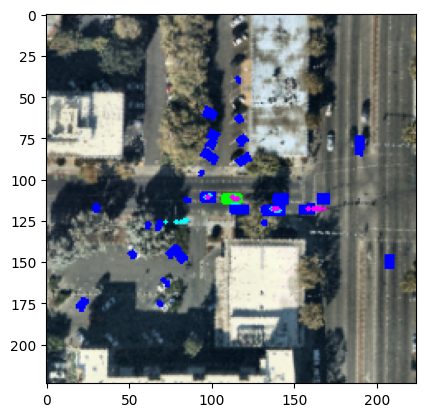

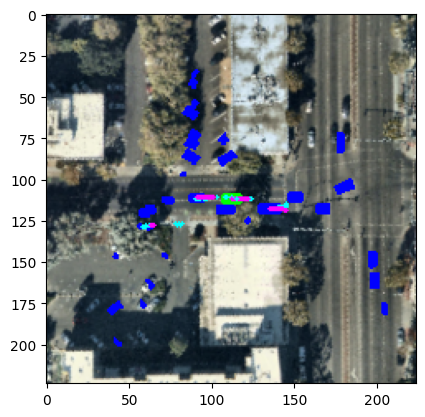

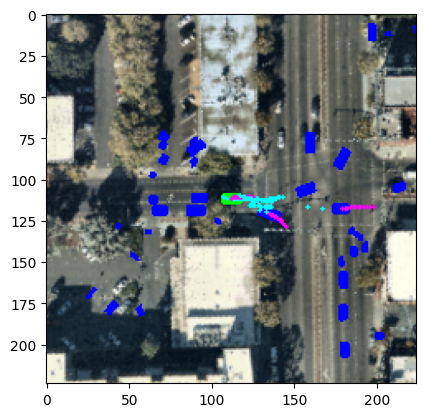

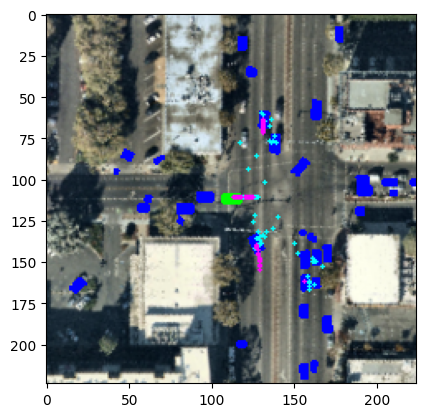

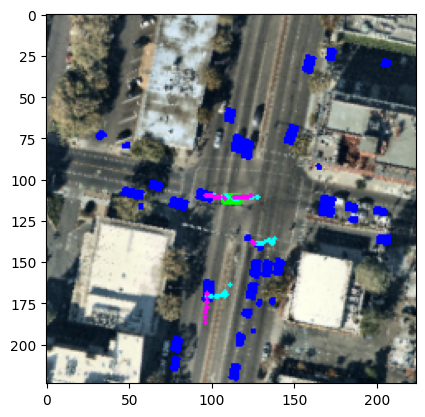

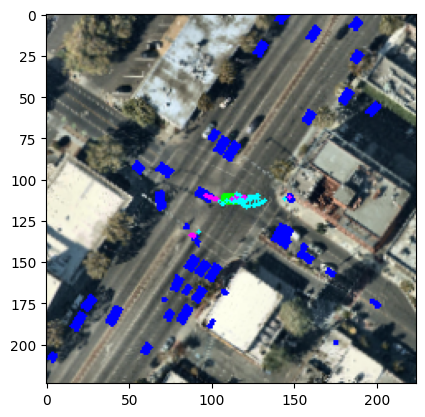

In [14]:
scene_id = 13


for frame_id in range(0, 255, 20):
    data = eval_dataset.get_scene_dataset(scene_id)[frame_id]
    tr_sample = eval_vector_dataset.get_scene_dataset(scene_id)[frame_id]
    vector_data = get_inputs_offline_rl(tr_sample)

    # todo 可以设置MPC的推断步数
    inference_mpc_step = 15
    num_other_agent_to_plot= 2

    # blue lines are planning/prediction, red lines are targets
    plot_offline_rl_planning_prediction(
        data,
        vector_data,
        inference=INFERENCE_MPC,
        inference_mpc_step=inference_mpc_step,
        num_other_agent_to_plot=num_other_agent_to_plot,
    )


## One-step

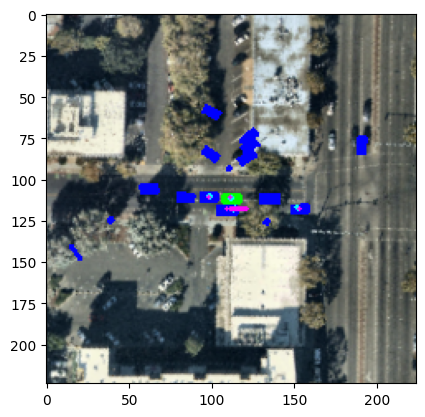

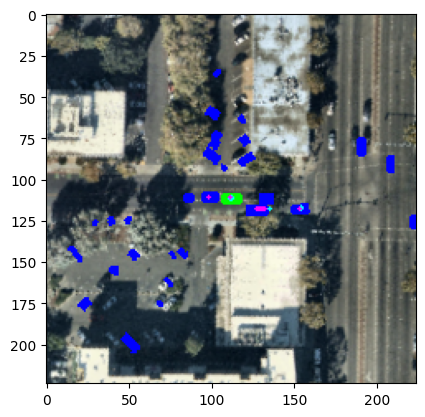

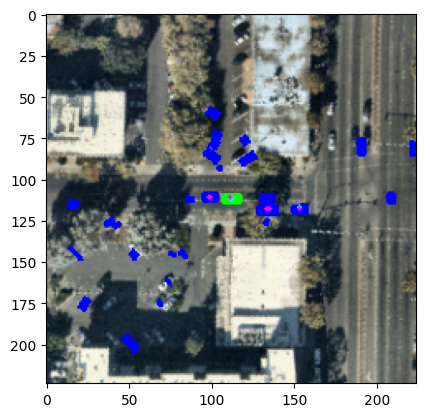

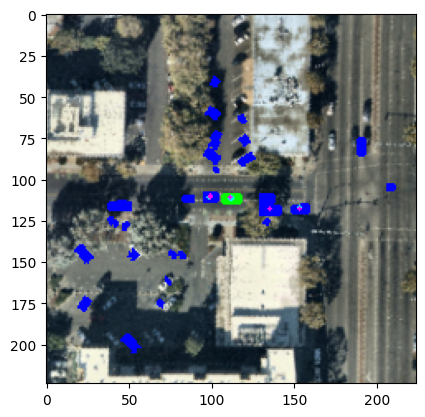

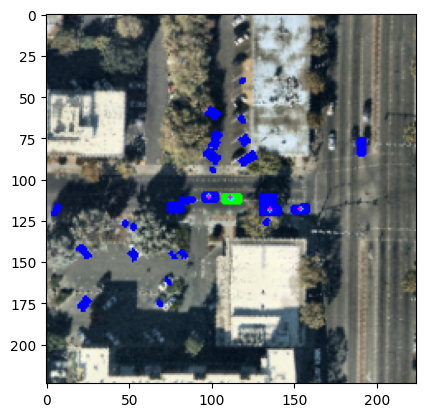

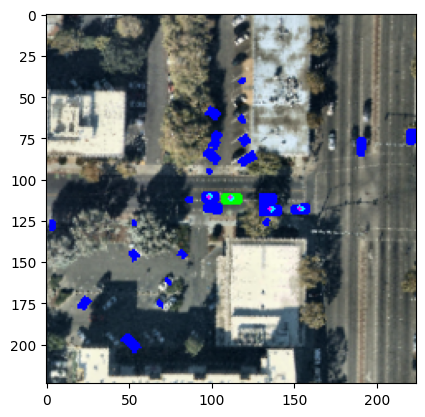

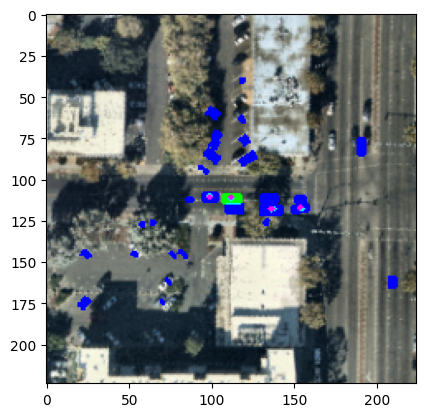

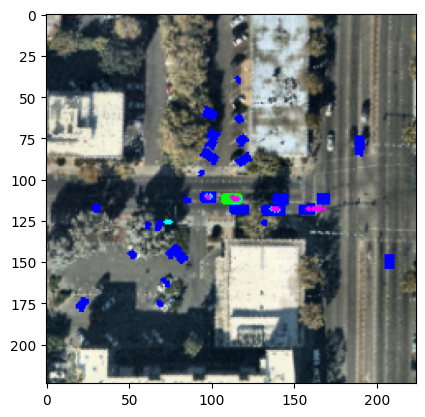

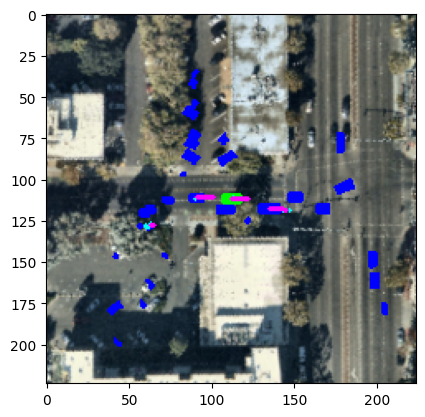

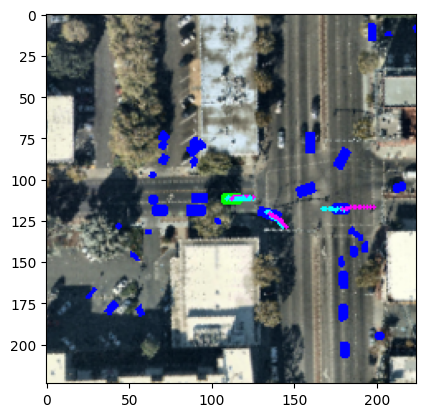

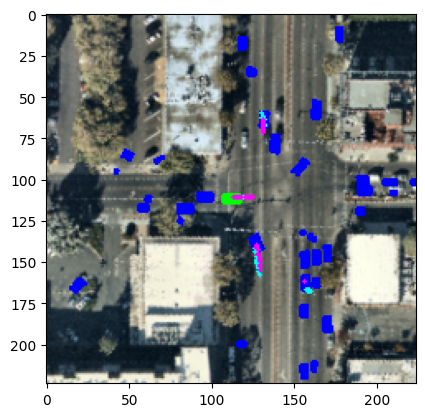

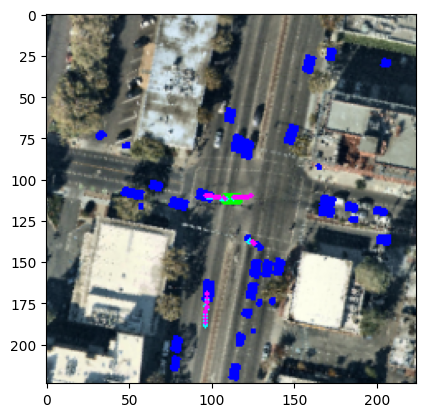

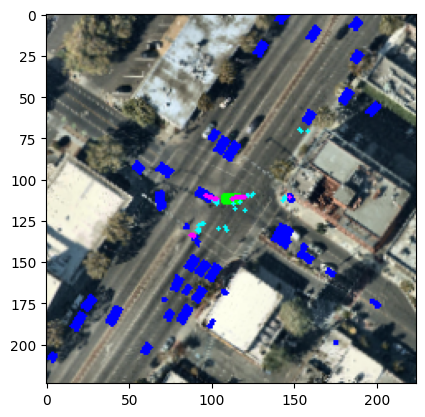

In [15]:
for frame_id in range(0, 255, 20):
    data = eval_dataset.get_scene_dataset(scene_id)[frame_id]
    tr_sample = eval_vector_dataset.get_scene_dataset(scene_id)[frame_id]
    vector_data = get_inputs_offline_rl(tr_sample)

    # todo 可以设置MPC的推断步数
    inference_mpc_step = 15
    num_other_agent_to_plot= 2

    # blue lines are planning/prediction, red lines are targets
    plot_offline_rl_planning_prediction(
        data,
        vector_data,
        inference=INFERENCE_ONE_STEP,
        num_other_agent_to_plot=num_other_agent_to_plot,
    )


# Qualitative evaluation

## Visualise results
We can also visualise some images with predicted and annotated trajectories using L5Kit visualisation features.

In this example, we draw 20 images from our dataset and we visualise predicted and annotated trajectories on top of them.

In [10]:
for frame_number in range(0, len(eval_dataset), len(eval_dataset) // 20):
    data = eval_dataloader.dataset[frame_number]
    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}
    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    target_positions = data["target_positions"]

    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(target_positions, data["raster_from_agent"])

    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)

    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)

    plt.imshow(im_ego)
    plt.axis("off")
    plt.show()

KeyError: 'lanes_mid'

## Visualise the open-loop

To visualise the open loop we can just repeat the same operations for the consecutive frames.

In this example, we show the first 200 frames for our dataset, plotting predicted and annotated trajectories.

**We want to stress this out again: this is an open loop evaluation, we are NOT controlling the AV with our predictions**

In [ ]:
from IPython.display import display, clear_output
import PIL

for frame_number in range(200):
    data = eval_dataloader.dataset[frame_number]

    data_batch = default_collate([data])
    data_batch = {k: v.to(device) for k, v in data_batch.items()}

    result = model(data_batch)
    predicted_positions = result["positions"].detach().cpu().numpy().squeeze()

    predicted_positions = transform_points(predicted_positions, data["raster_from_agent"])
    target_positions = transform_points(data["target_positions"], data["raster_from_agent"])

    im_ego = rasterizer.to_rgb(data["image"].transpose(1, 2, 0))
    draw_trajectory(im_ego, target_positions, TARGET_POINTS_COLOR)
    draw_trajectory(im_ego, predicted_positions, PREDICTED_POINTS_COLOR)

    clear_output(wait=True)
    display(PIL.Image.fromarray(im_ego))

# Pre-trained model results

We include here the open-loop results of one scene using one of our pre-trained model. The predicted trajectory is well overlapped with the annotated one.

![SegmentLocal](../../docs/images/planning/out_9_open.gif "segment")